# DMV MV104 database

data provided by dohmh, originally from DMV

map and categorize variables

### Variables given - from crash data
date/time of crash
* date - date of crash

person injured
* f_per_age
* f_per_sex - male, female
* f_per_role (f_per_role_doh) - driver, passenger, pedestrian, bicyclist, motorcyclist (dohmh was able to extract motorcylists), unknown
* f_per_ejected - ejected, not ejected, unknown
* f_per_loc - at intersection, not at intersection, unknown (majority are unknown)

injury information
* f_inj_status_num - 1-6, unknown
* f_inj_status - conscious stated, not conscious states, death
* f_inj_type - 14 types, unknown
* f_inj_loc - 12 locations, unknown

road information
* f_road_light - 5 types, unknown
* f_road_surf_bi - dry, not dry unknown
* f_road_surf - dry, flooded, muddy, slush, snow/ice, wet, unknown (almost all dry)
* f_road_weather - clear, cloudy, rain, snow, sleet, fog, other, unknown
* f_road_control - none, traffic signal, stop sign, other, unknown

vehicle information
* f_act_veh - what the vehicle the person was in was doing - need to narrow donw
* f_veh - car, suburban, pickup, van, truck, pedestrian, bicyclist, unknown
* f_veh_doh - car/van/pickup, truck, taxi, bus, other(bike, motorcycle, ped)
* f_oveh_doh - same as above. but with two more unknown vars 6 and 7


In [1]:
import pandas as pd
pd.options.display.max_rows = 130
pd.options.display.max_columns = 130

import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-poster')
plt.style.use('ggplot')


import sys
sys.path.insert(0,'/home/deena/Documents/data_munge/ModaCode/')
import moda

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


from DMV database, build two tables, one with 2 vehicle crashes, and one with ped/bicycle crashes.

In [2]:
# read in DMV data

crash = moda.databridge("select * from anaphi.crash", encrypted='yes')
ind = moda.databridge("select * from anaphi.individual", encrypted='yes')
veh = moda.databridge("select * from anaphi.vehicle", encrypted='yes')

crash.drop(133,inplace=True)
ind.drop(484,inplace=True)

crash['year']=crash.CSACCDTE.str[:4]
crash['day']=crash.CSACCDTE.str[8:10]
crash['month']=crash.CSACCDTE.str[5:7]
crash['date'] = pd.to_datetime(crash[['year','month','day']])


veh.VEHBDYT_ID = pd.to_numeric(veh.VEHBDYT_ID,errors='coearse')
ind.INDIV_AGE = pd.to_numeric(ind.INDIV_AGE,errors='coearse')

print 'crash table',crash.shape
print 'person table', ind.shape
print 'vehicle table', veh.shape


/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


crash table (522108, 26)
person table (1502797, 22)
vehicle table (1092922, 20)


In [3]:
# only police reported PR
crashPR = crash[crash.POL_REPT=='Y']
indPR = ind[ind.CS_ID.isin(crashPR.CS_ID)&(~ind.INJT_ID.isin(['16','17','18']))]

print crash.shape, ind.shape, veh.shape

# combining data using person info at the row level.

base = indPR.drop(['ORG_HOSP_CDE','LAGSTP','LAGINJT','LAGHOSP'],axis=1)

#merging in crash info
base = base.merge(crash.drop(['RDSYST_ID'],axis=1),
                  how='left',on='CS_ID')
print 'base',base.shape

# keeping 2 veh crashes only
twoVeh = base[base.VEH_CNT=='2']

# merging in own vehicle info
twoVeh = twoVeh.merge(veh.drop(['CV_WEIGHT_LBS','SHZMTT_ID','DMV_VIN_NUM','CS_ID'],
                             axis=1),
                  how='left',on='CV_ID')
# own vehicle is requrired to be a motor vehicle (not pedestrian or bicycle)
twoVeh = twoVeh[(twoVeh.VEHBDYT_ID<100)&(twoVeh.VEHBDYT_ID>0)]

# other vehicle info
# only keeping motor vehicles (not pedestrians etc) 
vehMotor = veh[(veh.VEHBDYT_ID<100)&(veh.VEHBDYT_ID>0)]
vehMotor = vehMotor.drop(['CV_WEIGHT_LBS','SHZMTT_ID','DMV_VIN_NUM'],axis=1)

#dataframe to join crash and vehicle id's
cv = crash[crash.VEH_CNT=='2'][['CS_ID']].merge(vehMotor[['CS_ID','CV_ID']],
                                           how='left',on='CS_ID')
cv.columns=['CS_ID','CV2_ID']

twoVeh = twoVeh.merge(cv,how='left',on='CS_ID')
twoVeh = twoVeh[~(twoVeh.CV_ID==twoVeh.CV2_ID)]
twoVeh = twoVeh.merge(vehMotor.add_suffix('_other'),
                  how='left',left_on='CV2_ID',right_on='CV_ID_other')
print 'two veh', twoVeh.shape

# only keeping 1 veh crashes
ped = base[(base.CIROLET_ID.isin(['6','7','14']))&(base.VEH_CNT=='1')]

# bring in other vehicle info

#dataframe to join crash and vehicle id's
cv1 = crash[crash.VEH_CNT=='1'][['CS_ID']].merge(vehMotor[['CS_ID','CV_ID']],
                                           how='left',on='CS_ID')
cv1.columns=['CS_ID','CV2_ID']

ped = ped.merge(cv1,how='left',on='CS_ID')
ped = ped[~(ped.CV_ID==ped.CV2_ID)]
ped = ped.merge(vehMotor.add_suffix('_other'),
                how='left',left_on='CV2_ID', right_on='CV_ID_other')

# merge in driver info
driver = indPR[indPR.CIROLET_ID=='1'].drop(['ORG_HOSP_CDE','LAGSTP','LAGINJT','LAGHOSP'],axis=1)

ped = ped.merge(driver.add_suffix('_driver'), how='left',left_on='CV_ID_other',
         right_on='CV_ID_driver')
ped = ped[~(ped.duplicated('CI_ID'))] #one of the drivers is duplicated, so dropping.

print 'ped',ped.shape

(522108, 26) (1502797, 22) (1092922, 20)
base (1114090, 42)
two veh (651501, 75)
ped (95292, 78)


## variables
* reformating variables
* all transformed variables prefixed with f

In [4]:
#injury variables f_inj
# injury type
inj_type = {1: 'Amputation',
2 : 'Concusion',
3 : 'Internal',
4 : 'Minor Bleeding',
5 : 'Severe Bleeding',
6 : 'Burn',#'Minor Burn',
7 : 'Burn',#'Moderate Burn',
8 : 'Burn',#'Severe Burn',
9 : 'Fracture-Dislocation',
10 : 'Contusion-Bruise',
11 : 'Abrasion',
12 : 'Complaint of Pain',
13 : 'None Visible',
14 : 'Whiplash'}

ped['f_inj_type'] = ped.INJT_ID.astype('float').map(inj_type)
twoVeh['f_inj_type'] = twoVeh.INJT_ID.astype('float').map(inj_type)

###
# injury status
status = {1:'death',
          2:'not conscious states',3:'not conscious states',4:'not conscious states',
          5:'conscious states',6:'conscious states'}

ped['f_inj_status'] = ped.EMTNSTATT_CDE.astype(float).map(status)
twoVeh['f_inj_status'] = twoVeh.EMTNSTATT_CDE.astype(float).map(status)

###
# injury location
inj_loc = {1 : 'Head',
           2 : 'Face',
           3 : 'Face',#'Eye',
           4 : 'Neck',
           5 : 'Chest',
           6 : 'Back',
           7 : 'Shoulder-Upper Arm',
           8 : 'Elbow-Lower Arm-Hand',
           9 : 'Abdomen-Pelvis',
           10 : 'Hip-Upper Leg',
           11 : 'Knee-Lower Leg-Foot',
           12 : 'Entire Body'}

ped['f_inj_loc'] = ped.INJLOCT_CDE.astype(float).map(inj_loc)
twoVeh['f_inj_loc'] = twoVeh.INJLOCT_CDE.astype(float).map(inj_loc)

###
# person variables f_per

sex = {'M':'male','m':'male',
       'F':'female','f':'female'}

ped['f_per_sex'] = ped.CI_SEX_CDE.map(sex)
ped['f_driver_sex'] = ped.CI_SEX_CDE_driver.map(sex)
twoVeh['f_per_sex'] = twoVeh.CI_SEX_CDE.map(sex)

###
# age

ped['f_per_age'] = ped.INDIV_AGE
ped['f_driver_age'] = ped.INDIV_AGE_driver
ped['f_per_age_dec'] = (np.floor(ped.f_per_age/10)*10).astype(float).astype(str)
ped['f_driver_age_dec'] = (np.floor(ped.f_driver_age/10)*10).astype(str)

twoVeh['f_per_age'] = pd.to_numeric(twoVeh.INDIV_AGE)
twoVeh['f_per_age_dec'] = (np.floor(twoVeh.f_per_age/10)*10).astype(float).astype(str)

###
# role

role = {1:'driver',2:'passenger',
        6:'pedestrian',9:'pedestrian',
        7:'bicyclist',14:'bicyclist'}
# not sure what 11=Registrant means, keeping it as unknown.

ped['f_per_role'] = ped.CIROLET_ID.astype('int').map(role)
twoVeh['f_per_role'] = twoVeh.CIROLET_ID.astype('int').map(role)

###
# ejected from vehicle

ejected = {1 : 'not ejected',2:'ejected',3:'ejected'}

twoVeh['f_per_eject'] = twoVeh.EJCTT_ID.astype(float).map(ejected)

###
# pedestrian/bicyclist at interesection
loc = {'1':'at intersection','2':'not at intersection'}

ped['f_per_loc'] = ped.PBLOCT_ID.map(loc)

###
# road conditions f_road

# day light condition

light = {1 : 'Daylight',
         2 : 'Dawn/Dusk',
         3 : 'Dawn/Dusk',
         4 : 'Dark-Road', #lit
         5 : 'Dark-Road'} #unlit

ped['f_road_light'] = ped.LGHTCNDT_ID.astype(int).map(light)
twoVeh['f_road_light'] = twoVeh.LGHTCNDT_ID.astype(int).map(light)

###
# time of day
ped['f_period'] = np.floor(ped.HR1.astype(float)/3)
twoVeh['f_period'] = np.floor(twoVeh.HR1.astype(float)/3)

###
# road surface
surf = {1 : 'Dry',
           2 : 'Not Dry',
           3 : 'Not Dry',
           4 : 'Not Dry',
           5 : 'Not Dry',
           6 : 'Not Dry'}       
ped['f_road_surf'] = ped.RDSRFT_ID.astype(int).map(surf)
twoVeh['f_road_surf'] = twoVeh.RDSRFT_ID.astype(int).map(surf)

###
# weather
weather = {
1 : 'Clear',
2 : 'Cloudy',
3 : 'Percipitation',#'Rain',
4 : 'Percipitation',#'Snow',
5 : 'Percipitation',#'Sleet/Hail/Freezing Rain',
6 : 'Cloudy',#'Fog/Smog/Smoke',
#9 : 'Other' 
}
ped['f_road_weather'] = ped.WTHRT_ID.astype(int).map(weather)
twoVeh['f_road_weather'] = twoVeh.WTHRT_ID.astype(int).map(weather)

###
# traffic control
control ={'1' : 'None',
'2' : 'Traffic signal',
'3' : 'Stop sign',
'4' : 'Other',#'Flashing light',
'5' : 'Other',#'Yield sign',
'6' : 'Other',#'Officer/Flagman/Guard',
'7' : 'Other',#'No passing zone',
'8' : 'Other',#'RR crossing sign',
'9' : 'Other',#'RR crossing flash light',
'10' : 'Other',#'RR crossing gates',
'11' : 'Other',#'Stopped school bus w/ red light flash',
'12' : 'Other',#'Highway work area (construction)',
'13' : 'Other',#'Maintenance work area',
'14' : 'Other',#'Utility work area',
'15' : 'Other',#'Police/Fire emergency',
'16' : 'Other',#'School zone',
'20' : 'Other'}

ped['f_road_control'] = ped.TFCCTRLT_ID.map(control)
twoVeh['f_road_control'] = twoVeh.TFCCTRLT_ID.map(control)

###
# pre-collision action f_act

# pedestrian bicyclist action
# even if the injured is not a pedestrian, this can be filled out
# it comes from the DMV crash table
pedaction = {
1 : 'Crossing, With Signal',
2 : 'Crossing, Against Signal',
3 : 'Crossing, No Signal, Marked Crosswalk',
4 : 'Crossing, No Signal or Crosswalk',
5 : 'Along Highway',
6 : 'Along Highway',
7 : 'Other',#'Emerging from in Front of/Behind Parked Vehicle',
8 : 'Other',#'Going to/From Stopped School Bus',
9 : 'Other',#'Getting On/Off Vehicle Other than School Bus',
10 : 'Other',#'Pushing/Working on Car',
11 : 'Other',#'Working in Roadway',
12 : 'Other',#'Playing in Roadway',
13 : 'Other',#'Other Acrions in Roadway',
14 : 'Other',#'Not in Roadway (Indicate)'
}
ped['f_act_ped'] = pd.to_numeric(ped.PBACTT_DMV_CDE).map(pedaction)

###
# vehicle action
action = {
1 : 'Going Straight Ahead',
2 : 'Making Right Turn',
3 : 'Making Left Turn',
4 : 'Making Left Turn',#'Making U Turn',
5 : 'Stopping Starting',#'Starting from Parking',
6 : 'Stopping Starting',#'Starting in Traffic',
7 : 'Stopping Starting',#'Slowing or Stopping',
8 : 'Stopping Starting',#'Stopped in Traffic',
9 : 'Stopping Starting',#'Entering Parked Position',
10 : 'Stopping Starting',#'Parked',
11 : 'Other',#'Avoiding Object in Roadway',
12 : 'Other',#'Changing Lanes',
13 : 'Other',#'Overtaking/Passing',
14 : 'Other',#'Merging',
15 : 'Backing',
16 : 'Making Right Turn',
17 : 'Making Left Turn',
18 : 'Other',#'Police Pursuit',
20 : 'Other'}

ped['f_act_veh'] = ped.PACCACTT_ID_other.astype(float).map(action)
twoVeh['f_act_veh'] = twoVeh.PACCACTT_ID.astype(float).map(action)
twoVeh['f_act_veh_other'] = twoVeh.PACCACTT_ID_other.astype(float).map(action)

###
# vehicle body type
vehicle = {
1 : 'Car',
2 : 'Truck',
3 : 'Car',
4 : 'Car',
5 : 'Suburban',
6 : 'Car',
7 : 'Car',    
10 : 'Motorcycle',
11 : 'Car',
12 : 'Car',    
15 : 'Truck',
16 : 'Car',
22 : 'Truck',
27 : 'Truck',   
28 : 'Truck',
33 : 'Truck',
34 : 'Truck',
40 : 'Truck',
41 : 'Truck',
42 : 'Truck',
43 : 'Truck',
44 : 'Pickup',
45 : 'Truck',
46 : 'Truck',
47 : 'Truck',
48 : 'Truck',
49 : 'Van',
50 : 'Truck',
51 : 'Truck',
52 : 'Truck',
53 : 'Truck',
55 : 'Truck',
65 : 'Truck',
57 : 'Truck',
59 : 'Truck',
60 : 'Bus',
63 : 'Car',
101 : 'Pedestrian',
102 : 'Pedestrian',
103 : 'Bicyclist',
}

ped['f_veh'] = ped.VEHBDYT_ID_other.map(vehicle)
twoVeh['f_veh'] = twoVeh.VEHBDYT_ID.map(vehicle)
twoVeh['f_veh_other'] = twoVeh.VEHBDYT_ID_other.map(vehicle)

# final cleaning - fill all blanks
ped.fillna('unknown',inplace=True)
twoVeh.fillna('unknown',inplace=True)

In [5]:
ped.groupby('CI_SEX_CDE').count()

,CS_ID,CI_ID,CV_ID,EMTNSTATT_CDE,CIROLET_ID,STPSTNT_ID,EJCTT_ID,CI_LICENSE_STATE_CDE,SFTYEQPT_ID,SEVERITY,INDIV_AGE,EMST_CDE,INJT_ID,INJLOCT_CDE,HOSP,LAGSEV,LAGEMS,NYSACCT_ID,CSACCTIME,CSACCDTE,ACCDAY,HR1,MIN1,LGHTCNDT_ID,MUNIT_ID,CLSNMNRT_ID,CS_CNTYT_ID,RDCHART_ID,WTHRT_ID,TFCCTRLT_ID,RDSRFT_ID,CS_REF_MARKER,PBLOCT_ID,PBACTT_DMV_CDE,EVNTT_ID,VEH_CNT,POL_REPT,year,day,month,date,CV2_ID,CS_ID_other,CV_ID_other,VEHBDYT_ID_other,REGT_CDE_other,PACCACTT_ID_other,TBCT_DMV_CDE_other,DIRCTT_CDE_other,FT_ID_other,CV_VEH_YEAR_other,CV_REG_STATE_CDE_other,CV_PSGR_NUM_other,CV_CYLNDR_other,CV_VEHMAKE_DESCR_other,CFT_CDE1_other,CFT_CDE2_other,VEH_EVNTT_ID_other,VIN_other,CS_ID_driver,CI_ID_driver,CV_ID_driver,EMTNSTATT_CDE_driver,CIROLET_ID_driver,STPSTNT_ID_driver,EJCTT_ID_driver,CI_LICENSE_STATE_CDE_driver,CI_SEX_CDE_driver,SFTYEQPT_ID_driver,SEVERITY_driver,INDIV_AGE_driver,EMST_CDE_driver,INJT_ID_driver,INJLOCT_CDE_driver,HOSP_driver,LAGSEV_driver,LAGEMS_driver,f_inj_type,f_inj_status,f_inj_loc,f_per_sex,f_driver_sex,f_per_age,f_driver_age,f_per_age_dec,f_driver_age_dec,f_per_role,f_per_loc,f_road_light,f_period,f_road_surf,f_road_weather,f_road_control,f_act_ped,f_act_veh,f_veh
CI_SEX_CDE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201,40201
M,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920,54920
U,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87
f,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
m,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
unknown,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80


In [6]:
ped.fillna('-').groupby('CI_SEX_CDE_driver').count()

,CS_ID,CI_ID,CV_ID,EMTNSTATT_CDE,CIROLET_ID,STPSTNT_ID,EJCTT_ID,CI_LICENSE_STATE_CDE,CI_SEX_CDE,SFTYEQPT_ID,SEVERITY,INDIV_AGE,EMST_CDE,INJT_ID,INJLOCT_CDE,HOSP,LAGSEV,LAGEMS,NYSACCT_ID,CSACCTIME,CSACCDTE,ACCDAY,HR1,MIN1,LGHTCNDT_ID,MUNIT_ID,CLSNMNRT_ID,CS_CNTYT_ID,RDCHART_ID,WTHRT_ID,TFCCTRLT_ID,RDSRFT_ID,CS_REF_MARKER,PBLOCT_ID,PBACTT_DMV_CDE,EVNTT_ID,VEH_CNT,POL_REPT,year,day,month,date,CV2_ID,CS_ID_other,CV_ID_other,VEHBDYT_ID_other,REGT_CDE_other,PACCACTT_ID_other,TBCT_DMV_CDE_other,DIRCTT_CDE_other,FT_ID_other,CV_VEH_YEAR_other,CV_REG_STATE_CDE_other,CV_PSGR_NUM_other,CV_CYLNDR_other,CV_VEHMAKE_DESCR_other,CFT_CDE1_other,CFT_CDE2_other,VEH_EVNTT_ID_other,VIN_other,CS_ID_driver,CI_ID_driver,CV_ID_driver,EMTNSTATT_CDE_driver,CIROLET_ID_driver,STPSTNT_ID_driver,EJCTT_ID_driver,CI_LICENSE_STATE_CDE_driver,SFTYEQPT_ID_driver,SEVERITY_driver,INDIV_AGE_driver,EMST_CDE_driver,INJT_ID_driver,INJLOCT_CDE_driver,HOSP_driver,LAGSEV_driver,LAGEMS_driver,f_inj_type,f_inj_status,f_inj_loc,f_per_sex,f_driver_sex,f_per_age,f_driver_age,f_per_age_dec,f_driver_age_dec,f_per_role,f_per_loc,f_road_light,f_period,f_road_surf,f_road_weather,f_road_control,f_act_ped,f_act_veh,f_veh
CI_SEX_CDE_driver,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467,18467
M,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608,59608
U,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31
f,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
m,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
unknown,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135,17135


### injury level: f_inj

In [7]:
ped.fillna('-').groupby(['f_inj_type','INJT_ID']).count()[['CI_ID']]

CI_ID
f_inj_type           INJT_ID       
Abrasion             11        6012
Amputation           1          145
Burn                 6          349
                     7           93
                     8           95
Complaint of Pain    12       48494
Concusion            2         1307
Contusion-Bruise     10        7334
Fracture-Dislocation 9         3655
Internal             3         1254
Minor Bleeding       4         7495
None Visible         13       11334
Severe Bleeding      5         2314
Whiplash             14         223
unknown              -1        4934
                     -2           5
                     -3         187
                     unknown     62

In [8]:
twoVeh.fillna('-').groupby(['f_inj_type','INJT_ID']).count()[['CI_ID']]

CI_ID
f_inj_type           INJT_ID        
Abrasion             11         3165
Amputation           1           257
Burn                 6           927
                     7           170
                     8           112
Complaint of Pain    12       144643
Concusion            2          2217
Contusion-Bruise     10         4372
Fracture-Dislocation 9          1361
Internal             3          1989
Minor Bleeding       4          6415
None Visible         13        53670
Severe Bleeding      5          1006
Whiplash             14        11344
unknown              -1        12551
                     -2         1888
                     -3       363183
                     unknown   42231

In [9]:
ped.fillna('-').groupby(['f_inj_status','EMTNSTATT_CDE']).count()[['CI_ID']]

CI_ID
f_inj_status         EMTNSTATT_CDE       
conscious states     5               2343
                     6              83868
death                1                434
not conscious states 2               1157
                     3               1919
                     4                810
unknown              -1              4493
                     -2                 2
                     -3               266

In [10]:
ped.fillna('-').groupby(['SEVERITY','f_inj_status']).count()[['CI_ID']]

CI_ID
SEVERITY f_inj_status               
A        conscious states       6522
         not conscious states   3490
B        conscious states      19685
C        conscious states      57285
K        conscious states        128
         death                   434
         not conscious states    396
         unknown                  27
O        conscious states       2406
         unknown                1952
Z        conscious states        185
         unknown                2782

In [11]:
twoVeh.fillna('-').groupby(['f_inj_status','EMTNSTATT_CDE']).count()[['CI_ID']]

CI_ID
f_inj_status         EMTNSTATT_CDE        
conscious states     5                4630
                     6              227071
death                1                 169
not conscious states 2                 940
                     3                1263
                     4                 819
unknown              -1               9287
                     -2                531
                     -3             386357
                     unknown         20434

In [12]:
twoVeh.fillna('-').groupby(['SEVERITY','f_inj_status']).count()[['CI_ID']]

CI_ID
SEVERITY f_inj_status                
A        conscious states        6327
         death                      1
         not conscious states    2920
B        conscious states       13918
C        conscious states      196797
K        conscious states          40
         death                    168
         not conscious states     102
         unknown                    8
O        conscious states       13203
         unknown               409225
Z        conscious states        1416
         unknown                 7376

In [13]:
ped.fillna('-').groupby(['f_inj_loc','INJLOCT_CDE']).count()[['CI_ID']]

CI_ID
f_inj_loc            INJLOCT_CDE       
Abdomen-Pelvis       9             1721
Back                 6             6792
Chest                5             1057
Elbow-Lower Arm-Hand 8             8647
Entire Body          12           10667
Face                 2             2441
                     3              136
Head                 1            11913
Hip-Upper Leg        10            8769
Knee-Lower Leg-Foot  11           27531
Neck                 4             2752
Shoulder-Upper Arm   7             5938
unknown              -1            6667
                     -2               6
                     -3             193
                     unknown         62

In [14]:
twoVeh.fillna('-').groupby(['f_inj_loc','INJLOCT_CDE']).count()[['CI_ID']]

CI_ID
f_inj_loc            INJLOCT_CDE        
Abdomen-Pelvis       9              4138
Back                 6             42891
Chest                5             11688
Elbow-Lower Arm-Hand 8              9393
Entire Body          12            27061
Face                 2              5772
                     3               610
Head                 1             25935
Hip-Upper Leg        10             3429
Knee-Lower Leg-Foot  11            14976
Neck                 4             56931
Shoulder-Upper Arm   7             11776
unknown              -1            29542
                     -2             1907
                     -3           363221
                     unknown       42231

### person level: f_per

In [15]:
ped.fillna('_').groupby(['f_per_sex','CI_SEX_CDE']).count()[['CI_ID']]

CI_ID
f_per_sex CI_SEX_CDE       
female    F           40201
          f               3
male      M           54920
          m               1
unknown   U              87
          unknown        80

In [16]:
ped.fillna('_').groupby(['f_driver_sex','CI_SEX_CDE_driver']).count()[['CI_ID']]

CI_ID
f_driver_sex CI_SEX_CDE_driver       
female       F                  18467
             f                     17
male         M                  59608
             m                     34
unknown      U                     31
             unknown            17135

In [17]:
twoVeh.fillna('_').groupby(['f_per_sex','CI_SEX_CDE']).count()[['CI_ID']]

CI_ID
f_per_sex CI_SEX_CDE        
female    F           240619
          f              708
male      M           387426
          m             1177
unknown   C                7
          U              526
          unknown      21037
          x                1

In [41]:
ped[ped.CI_SEX_CDE_driver=='unknown'].groupby('VEHBDYT_ID_other').count()[['CI_ID']]

,CI_ID
VEHBDYT_ID_other,
1.0,34
2.0,3
3.0,23
4.0,242
5.0,1910
6.0,2401
7.0,178
9.0,1
10.0,61


bodytype 17 is unknown vehicle - I'm guessing these are hit and runs? or maybe the cop doesn't always record the vehicle and driver info?

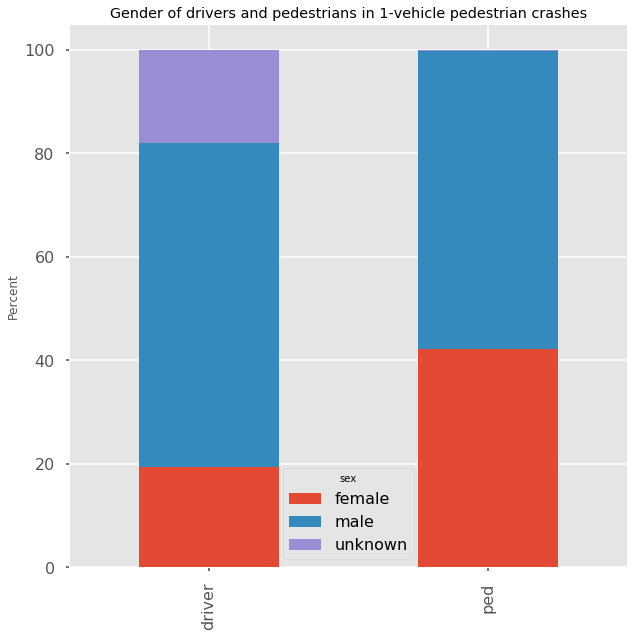

In [45]:
title = 'Gender of drivers and pedestrians in 1-vehicle pedestrian crashes'
pedSexCount = ped.groupby('f_per_sex').count()[['CI_ID']]/ped.shape[0]*100
pedSexCount.columns=['ped']
pedSexCount.index.name = 'sex'

driverSexCount = ped.groupby('f_driver_sex').count()[['CI_ID']]/ped.shape[0]*100
driverSexCount.columns = ['driver']
driverSexCount.index.name = 'sex'
driverSexCount.join(pedSexCount).T.plot(kind='bar',
                                        stacked=True,
                                        figsize=(10,10),
                                        title=title)
plt.ylabel('Percent')

In [20]:
ped.groupby('f_driver_sex').count()[['CI_ID']]

,CI_ID
f_driver_sex,
female,18484
male,59642
unknown,17166


In [21]:
ped.groupby(['f_per_role','CIROLET_ID']).count()[['CI_ID']]

CI_ID
f_per_role CIROLET_ID       
bicyclist  14            151
           7           22126
pedestrian 6           73015

In [22]:
twoVeh.groupby(['f_per_role','CIROLET_ID']).count()[['CI_ID']]

CI_ID
f_per_role CIROLET_ID        
driver     1           370012
passenger  2           236321
pedestrian 9                2
unknown    11           24732
           15           20434

In [23]:
twoVeh.fillna('-').groupby(['EJCTT_ID','f_per_eject']).count()[['CI_ID']]

,,CI_ID
EJCTT_ID,f_per_eject,
-1,unknown,5933
-2,unknown,62
-3,unknown,23572
1,not ejected,595978
2,ejected,1045
3,ejected,4477
unknown,unknown,20434


In [24]:
ped.fillna('-').groupby(['f_per_loc','PBLOCT_ID']).count()[['CI_ID']]

CI_ID
f_per_loc           PBLOCT_ID       
at intersection     1          44732
not at intersection 2          16997
unknown             -1          5238
                    -2             1
                    unknown    28324

### road conditions: f_road

In [25]:
ped.fillna('-').groupby(['f_road_light','LGHTCNDT_ID']).count()[['CI_ID']]

CI_ID
f_road_light LGHTCNDT_ID       
Dark-Road    4            28162
             5              676
Dawn/Dusk    2             1837
             3             4441
Daylight     1            58735
unknown      -1            1441

In [26]:
twoVeh.fillna('-').groupby(['f_road_light','LGHTCNDT_ID']).count()[['CI_ID']]

CI_ID
f_road_light LGHTCNDT_ID        
Dark-Road    4            194566
             5              2657
Dawn/Dusk    2             12321
             3             24849
Daylight     1            407537
unknown      -1             9571

In [27]:
ped.fillna('-').groupby(['f_road_surf','RDSRFT_ID']).count()[['CI_ID']]

CI_ID
f_road_surf RDSRFT_ID       
Dry         1          75845
Not Dry     2          16283
            3             34
            4           1260
            5            368
            6             36
unknown     -1          1435
            7             31

In [28]:
twoVeh.fillna('-').groupby(['f_road_surf','RDSRFT_ID']).count()[['CI_ID']]

CI_ID
f_road_surf RDSRFT_ID        
Dry         1          519317
Not Dry     2          108861
            3             174
            4           12104
            5            2118
            6             296
unknown     -1           8330
            7             301

In [29]:
ped.fillna('-').groupby(['f_road_weather','WTHRT_ID']).count()[['CI_ID']]

CI_ID
f_road_weather WTHRT_ID       
Clear          1         69568
Cloudy         2         10736
               6           106
Percipitation  3         11847
               4          1065
               5           344
unknown        -1         1595
               9            31

In [30]:
twoVeh.fillna('-').groupby(['f_road_weather','WTHRT_ID']).count()[['CI_ID']]

CI_ID
f_road_weather WTHRT_ID        
Clear          1         469734
Cloudy         2          85305
               6            909
Percipitation  3          74872
               4           8702
               5           2193
unknown        -1          9592
               9            194

In [31]:
ped.fillna('-').groupby(['f_road_control','TFCCTRLT_ID']).count()[['CI_ID']]

CI_ID
f_road_control TFCCTRLT_ID       
None           1            33523
Other          10               3
               11              50
               12             132
               13              13
               14              27
               15             302
               4              152
               5               61
               6              209
               7               40
               8               23
               9                6
Stop sign      3             5887
Traffic signal 2            51249
unknown        -1            3460
               -2              36
               18              46
               19              73

In [32]:
twoVeh.fillna('-').groupby(['f_road_control','TFCCTRLT_ID']).count()[['CI_ID']]

CI_ID
f_road_control TFCCTRLT_ID        
None           1            247537
Other          10               35
               11              364
               12             2994
               13              226
               14              112
               15            13488
               4              1155
               5              2595
               6               658
               7               619
               8                35
               9                 5
Stop sign      3             79584
Traffic signal 2            266648
unknown        -1            33786
               -2              710
               18              864
               19               86

### time of day

In [33]:
ped.groupby(['f_period','HR1']).count()[['CI_ID']]

CI_ID
f_period HR1           
0.0      0         1626
         1         1164
         2          838
1.0      3          722
         4          827
         5          845
2.0      6         1582
         7         2647
         8         4862
3.0      10        3840
         11        4010
         9         4219
4.0      12        4677
         13        4976
         14        5842
5.0      15        6561
         16        6781
         17        7523
6.0      18        7785
         19        6826
         20        5920
7.0      21        4640
         22        3588
         23        2677
unknown  unknown    314

In [34]:
twoVeh.groupby(['f_period','HR1']).count()[['CI_ID']]

CI_ID
f_period HR1           
0.0      0        17173
         1        13454
         2        10254
1.0      3         8725
         4        10640
         5        10725
2.0      6        12871
         7        18381
         8        33102
3.0      10       27929
         11       29864
         9        30064
4.0      12       32411
         13       35409
         14       40439
5.0      15       41338
         16       49847
         17       45012
6.0      18       41020
         19       34710
         20       30468
7.0      21       26556
         22       25768
         23       23365
unknown  unknown   1976

### vehicle/pedestrian pre-accident action: f_act

In [35]:
ped.fillna('-').groupby(['f_act_ped','PBACTT_DMV_CDE']).count()[['CI_ID']]

CI_ID
f_act_ped                             PBACTT_DMV_CDE       
Along Highway                         5                7697
                                      6                2112
Crossing, Against Signal              2               11549
Crossing, No Signal or Crosswalk      4               13789
Crossing, No Signal, Marked Crosswalk 3                6259
Crossing, With Signal                 1               28840
Other                                 10                 22
                                      11                956
                                      12                909
                                      13               5008
                                      14               2208
                                      7                3486
                                      8                  67
                                      9                 859
unknown                               -1              11530
                                      -2                  1

In [36]:
ped.fillna('-').groupby(['f_act_veh','PACCACTT_ID_other']).count()[['CI_ID']]

CI_ID
f_act_veh            PACCACTT_ID_other       
Backing              15                  6554
Going Straight Ahead 1                  43512
Making Left Turn     17                   164
                     3                  23888
                     4                    846
Making Right Turn    16                   113
                     2                   8783
Other                11                   100
                     12                   270
                     13                   322
                     14                   179
                     18                    23
                     20                  1284
Stopping Starting    10                   490
                     5                   1367
                     6                    630
                     7                   1102
                     8                    864
                     9                   1135
unknown              -1                  3515
                     -2                    36
                     -3                    25
                     unknown               90

In [37]:
twoVeh.fillna('-').groupby(['f_act_veh','PACCACTT_ID']).count()[['CI_ID']]

CI_ID
f_act_veh            PACCACTT_ID        
Backing              15             7385
Going Straight Ahead 1            383940
Making Left Turn     17              765
                     3             53521
                     4              8303
Making Right Turn    16              230
                     2             22621
Other                11             1072
                     12            18185
                     13             3922
                     14             9016
                     18              196
                     20             7425
Stopping Starting    10            26426
                     5              6162
                     6              4667
                     7             45428
                     8             34692
                     9              2494
unknown              -1            14569
                     -2               70
                     -3              412

In [38]:
twoVeh.fillna('-').groupby(['f_act_veh_other','PACCACTT_ID_other']).count()[['CI_ID']]

CI_ID
f_act_veh_other      PACCACTT_ID_other        
Backing              15                   8188
Going Straight Ahead 1                  385194
Making Left Turn     17                    789
                     3                   52855
                     4                    9113
Making Right Turn    16                    228
                     2                   22564
Other                11                   1017
                     12                  18904
                     13                   4553
                     14                   9079
                     18                    214
                     20                   7501
Stopping Starting    10                  27724
                     5                    6617
                     6                    4864
                     7                   44817
                     8                   28472
                     9                    2550
unknown              -1                  15597
                     -2                     94
                     -3                    567

### vehicles type :  f_veh


need to work on this grouping and match it to DOHMH's derived groups.

In [39]:
ped.fillna('-').groupby(['f_veh','VEHBDYT_ID_other']).count()[['CI_ID']]

CI_ID
f_veh      VEHBDYT_ID_other       
Bus        60.0               1718
Car        1.0                 497
           3.0                 279
           4.0                 989
           6.0               34348
           7.0                2482
           11.0                  2
           12.0                  1
           16.0                554
           63.0               6107
Motorcycle 10.0                449
Pickup     44.0               1216
Suburban   5.0               26715
Truck      2.0                  44
           15.0                612
           22.0                 78
           33.0                  2
           34.0                  1
           40.0                180
           41.0                301
           42.0                229
           43.0                 63
           45.0                 23
           46.0                 25
           47.0                105
           48.0                101
           50.0                166
           52.0                  1
           55.0                  3
           57.0                  3
           59.0                  3
           65.0                 12
Van        49.0               3804
unknown    8.0                   5
           9.0                   2
           13.0                  5
           14.0                  1
           17.0              13949
           18.0                  1
           19.0                  1
           20.0                  1
           23.0                 14
           24.0                  1
           25.0                  2
           26.0                 14
           38.0                  1
           61.0                 72
           62.0                  1
           66.0                 18
           67.0                  1
           unknown              90

In [40]:
twoVeh.fillna('-').groupby(['f_veh','VEHBDYT_ID']).count()[['CI_ID']]

CI_ID
f_veh      VEHBDYT_ID        
Bus        60.0         13456
Car        1.0           5980
           3.0           2732
           4.0           6568
           6.0         280174
           7.0          24539
           11.0             1
           12.0             6
           16.0          4832
           63.0         21204
Motorcycle 10.0          6700
Pickup     44.0          6956
Suburban   5.0         192775
Truck      2.0           2007
           15.0          6922
           22.0           972
           27.0            25
           28.0             4
           33.0            39
           34.0            11
           40.0          3697
           41.0          3104
           42.0          2505
           43.0           604
           45.0           206
           46.0           275
           47.0           833
           48.0           684
           50.0          1941
           55.0            73
           57.0            48
           59.0             3
           65.0            94
Van        49.0         20239
unknown    8.0             65
           9.0             20
           13.0            73
           14.0            10
           17.0         40200
           18.0             2
           20.0             7
           21.0             8
           23.0            71
           24.0            17
           25.0             3
           26.0            95
           32.0            17
           35.0             1
           38.0             4
           39.0             3
           61.0           459
           62.0             9
           64.0             3
           66.0           221
           67.0             4